In [ ]:
!pip install optbinning pandas numpy matplotlib seaborn scikit-learn scipy


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:

def load_and_explore_data(file_path):
    """
    Load credit data and perform initial exploration
    """
    credit_data = pd.read_csv(file_path)

    print("=== Dataset Overview ===")
    print(f"Dataset shape: {credit_data.shape}")
    print(f"\nColumn names:\n{list(credit_data.columns)}")

    print("\n=== First 5 rows ===")
    display(credit_data.head())

    print("\n=== Statistical Summary ===")
    display(credit_data.describe())

    print("\n=== Target Variable Distribution ===")
    target_dist = credit_data['loan_status'].value_counts()
    print(target_dist)
    print(f"Default rate: {target_dist[1]/len(credit_data)*100:.2f}%")

    return credit_data
df = load_and_explore_data('/content/credit_risk_dataset.csv')


=== Dataset Overview ===
Dataset shape: (32581, 12)

Column names:
['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

=== First 5 rows ===


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4



=== Statistical Summary ===


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000



=== Target Variable Distribution ===
loan_status
0    25473
1     7108
Name: count, dtype: int64
Default rate: 21.82%


In [ ]:
def preprocess_credit_data(dataframe):
    """
    Cleaning and preparing credit data for modeling
    """

    processed_df = dataframe.copy()

    print("=== Handling Missing Values ===")
    missing_summary = processed_df.isnull().sum()
    print(missing_summary[missing_summary > 0])

    numerical_cols = processed_df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if processed_df[col].isnull().sum() > 0:
            median_val = processed_df[col].median()
            processed_df[col].fillna(median_val, inplace=True)
            print(f"Filled {col} missing values with median: {median_val}")

    categorical_cols = processed_df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if processed_df[col].isnull().sum() > 0:
            mode_val = processed_df[col].mode()[0]
            processed_df[col].fillna(mode_val, inplace=True)
            print(f"Filled {col} missing values with mode: {mode_val}")

    initial_rows = len(processed_df)
    processed_df = processed_df.dropna(subset=['loan_status'])
    final_rows = len(processed_df)
    print(f"Removed {initial_rows - final_rows} rows with missing target variable")

    return processed_df

clean_data = preprocess_credit_data(df)


=== Handling Missing Values ===
person_emp_length     895
loan_int_rate        3116
dtype: int64
Filled person_emp_length missing values with median: 4.0
Filled loan_int_rate missing values with median: 10.99
Removed 0 rows with missing target variable


In [ ]:
def setup_modeling_variables(dataframe):
    """
    Defining and organizing variables for credit scoring model
    """
    categorical_features = [
        'person_home_ownership',
        'loan_intent',
        'loan_grade',
        'cb_person_default_on_file'
    ]

    predictor_variables = [
        'person_age', 'person_income', 'person_home_ownership',
        'person_emp_length', 'loan_intent', 'loan_grade',
        'loan_amnt', 'loan_int_rate', 'loan_percent_income',
        'cb_person_default_on_file', 'cb_person_cred_hist_length'
    ]

    missing_vars = set(predictor_variables) - set(dataframe.columns)
    if missing_vars:
        raise ValueError(f"Missing variables in dataset: {missing_vars}")

    X = dataframe[predictor_variables]
    y = dataframe['loan_status']

    print("=== Variable Setup Complete ===")
    print(f"Total features: {len(predictor_variables)}")
    print(f"Categorical features: {len(categorical_features)}")
    print(f"Numerical features: {len(predictor_variables) - len(categorical_features)}")

    return X, y, categorical_features, predictor_variables

features, target, cat_vars, all_vars = setup_modeling_variables(clean_data)


=== Variable Setup Complete ===
Total features: 11
Categorical features: 4
Numerical features: 7


In [ ]:
from sklearn.model_selection import train_test_split

def create_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Create stratified train-test split for credit scoring
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    print("=== Data Split Summary ===")
    print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

    train_default_rate = y_train.mean()
    test_default_rate = y_test.mean()
    print(f"Training default rate: {train_default_rate:.3f}")
    print(f"Test default rate: {test_default_rate:.3f}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_train_test_split(features, target)


=== Data Split Summary ===
Training set: 26064 samples (80.0%)
Test set: 6517 samples (20.0%)
Training default rate: 0.218
Test default rate: 0.218


In [ ]:
from optbinning import BinningProcess

def create_optimal_bins(X_train, y_train, categorical_vars, variable_names):
    """
    Creating optimal bins for all variables using OptBinning
    """
    variable_selection_criteria = {
        "iv": {"min": 0.02, "max": 1.0}
    }

    binning_processor = BinningProcess(
        variable_names=variable_names,
        categorical_variables=categorical_vars,
        selection_criteria=variable_selection_criteria
    )

    print("=== Starting Optimal Binning Process ===")

    binning_processor.fit(X_train, y_train)

    X_train_binned = binning_processor.transform(X_train)

    print("Binning process completed successfully!")

    return binning_processor, X_train_binned


bin_processor, X_train_transformed = create_optimal_bins(X_train, y_train, cat_vars, all_vars)


=== Starting Optimal Binning Process ===
Binning process completed successfully!


In [ ]:
from optbinning import BinningProcess

def create_optimal_bins(X_train, y_train, categorical_vars, variable_names):
    """
    Creating optimal bins for all variables using OptBinning
    """
    variable_selection_criteria = {
        "iv": {"min": 0.02, "max": 1.0}  # Information Value thresholds
    }

    # Initialize binning process
    binning_processor = BinningProcess(
        variable_names=variable_names,
        categorical_variables=categorical_vars,
        selection_criteria=variable_selection_criteria
    )

    print("=== Starting Optimal Binning Process ===")
    # Fit binning process on training data
    binning_processor.fit(X_train, y_train)

    # Transform both training and test data
    X_train_binned = binning_processor.transform(X_train)

    print("Binning process completed successfully!")

    return binning_processor, X_train_binned

# Apply optimal binning
bin_processor, X_train_transformed = create_optimal_bins(X_train, y_train, cat_vars, all_vars)


=== Starting Optimal Binning Process ===
Binning process completed successfully!


In [ ]:
def analyze_variable_importance(binning_processor):
    """
    Analyze and display variable importance using Information Value
    """
    # Create summary of variable importance
    variable_summary = binning_processor.summary()

    # Check the actual column names
    print("Available columns in summary:", variable_summary.columns.tolist())

    # The OptBinning library typically uses different column names
    # Common variations: 'IV', 'Information Value', 'Characteristic', etc.
    iv_column = None
    variable_column = None

    # Try to find the IV column
    for col in variable_summary.columns:
        if 'IV' in str(col) or 'Information' in str(col):
            iv_column = col
            break

    # Try to find the variable/characteristic column
    for col in variable_summary.columns:
        if 'Variable' in str(col) or 'Characteristic' in str(col) or 'Feature' in str(col):
            variable_column = col
            break

    # If we can't find the expected columns, display the summary as-is
    if iv_column is None or variable_column is None:
        print("=== Variable Summary (Raw) ===")
        display(variable_summary)
        return variable_summary

    # Add interpretation based on IV values
    def interpret_iv(iv_value):
        if iv_value < 0.02:
            return "Not Predictive"
        elif iv_value < 0.1:
            return "Weak Predictive"
        elif iv_value < 0.3:
            return "Medium Predictive"
        elif iv_value < 0.5:
            return "Strong Predictive"
        else:
            return "Very Strong Predictive"

    variable_summary['Interpretation'] = variable_summary[iv_column].apply(interpret_iv)
    variable_summary = variable_summary.sort_values(iv_column, ascending=False)

    print("=== Variable Importance Analysis ===")
    display(variable_summary)

    # Plot variable importance
    plt.figure(figsize=(12, 8))
    plt.barh(variable_summary[variable_column], variable_summary[iv_column])
    plt.xlabel('Information Value (IV)')
    plt.title('Variable Importance for Credit Scoring Model')
    plt.gca().invert_yaxis()

    # Add interpretation colors
    colors = []
    for iv in variable_summary[iv_column]:
        if iv >= 0.5:
            colors.append('darkgreen')
        elif iv >= 0.3:
            colors.append('green')
        elif iv >= 0.1:
            colors.append('orange')
        else:
            colors.append('red')

    plt.gca().barh(variable_summary[variable_column], variable_summary[iv_column], color=colors)
    plt.tight_layout()
    plt.show()

    return variable_summary

# Analyze variable importance
importance_analysis = analyze_variable_importance(bin_processor)


Available columns in summary: ['name', 'dtype', 'status', 'selected', 'n_bins', 'iv', 'js', 'gini', 'quality_score']
=== Variable Summary (Raw) ===


,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,person_age,numerical,OPTIMAL,False,7,0.011128,0.001389,0.052203,0.00154
1,person_income,numerical,OPTIMAL,True,8,0.573963,0.066889,0.395805,0.239173
2,person_home_ownership,categorical,OPTIMAL,True,3,0.389704,0.047491,0.304529,0.706793
3,person_emp_length,numerical,OPTIMAL,True,8,0.05885,0.007327,0.136279,0.008683
4,loan_intent,categorical,OPTIMAL,True,6,0.088686,0.011024,0.162928,0.138983
5,loan_grade,categorical,OPTIMAL,True,4,0.845847,0.096629,0.440638,0.312717
6,loan_amnt,numerical,OPTIMAL,True,10,0.097241,0.011991,0.163733,0.126136
7,loan_int_rate,numerical,OPTIMAL,True,10,0.678533,0.078326,0.4142,0.382123
8,loan_percent_income,numerical,OPTIMAL,True,10,0.952405,0.104197,0.44406,0.0154
9,cb_person_default_on_file,categorical,OPTIMAL,True,2,0.16248,0.019916,0.164678,0.241604


In [ ]:
from sklearn.linear_model import LogisticRegression

def train_credit_model(X_train_binned, y_train):
    """
    Train logistic regression model on binned features
    """
    # Initialize logistic regression with balanced class weights
    credit_model = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    )

    print("=== Training Credit Scoring Model ===")
    # Fit the model
    credit_model.fit(X_train_binned, y_train)

    # Display model coefficients
    feature_names = [f"Var_{i}" for i in range(X_train_binned.shape[1])]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': credit_model.coef_[0],
        'Abs_Coefficient': np.abs(credit_model.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)

    print("Top 10 Most Important Features by Coefficient:")
    display(coef_df.head(10))

    return credit_model

# Train the model
model = train_credit_model(X_train_transformed, y_train)


=== Training Credit Scoring Model ===
Top 10 Most Important Features by Coefficient:


,Feature,Coefficient,Abs_Coefficient
3,Var_3,-1.415513,1.415513
4,Var_4,-1.104547,1.104547
0,Var_0,-0.929555,0.929555
7,Var_7,-0.887183,0.887183
1,Var_1,-0.709844,0.709844
5,Var_5,-0.535640,0.535640
6,Var_6,-0.158220,0.158220
2,Var_2,0.046431,0.046431
8,Var_8,-0.016782,0.016782


In [ ]:
from optbinning import Scorecard

def build_credit_scorecard(binning_processor, model, X_train, y_train):
    """
    Build comprehensive credit scorecard
    """
    # Define scorecard parameters
    scorecard_params = {
        'odds': 1,           # Odds at base score
        'pdo': 20,           # Points to double odds
        'scorecard_points': 500  # Base score points
    }

    print("=== Building Credit Scorecard ===")

    # Create scorecard object
    credit_scorecard = Scorecard(
        binning_process=binning_processor,
        estimator=model,
        scaling_method="pdo_odds",
        scaling_method_params=scorecard_params,
        intercept_based=True
    )

    # Fit scorecard
    credit_scorecard.fit(X_train, y_train)

    print("Credit scorecard built successfully!")

    return credit_scorecard

# Build scorecard
scorecard = build_credit_scorecard(bin_processor, model, X_train, y_train)


=== Building Credit Scorecard ===
Credit scorecard built successfully!


In [ ]:
def calculate_credit_scores(scorecard, X_test, y_test):
    """
    Calculate credit scores and assign ratings
    """
    # Calculate scores
    credit_scores = scorecard.score(X_test)

    # Create results dataframe
    results_df = X_test.copy()
    results_df['credit_score'] = credit_scores
    results_df['actual_default'] = y_test.reset_index(drop=True)

    # Define credit rating function
    def assign_credit_rating(score):
        if score >= 650:
            return "Excellent"
        elif score >= 600:
            return "Very Good"
        elif score >= 550:
            return "Good"
        elif score >= 500:
            return "Above Average"
        elif score >= 450:
            return "Average"
        elif score >= 400:
            return "Below Average"
        elif score >= 350:
            return "Poor"
        else:
            return "Very Poor"

    # Assign credit ratings
    results_df['credit_rating'] = results_df['credit_score'].apply(assign_credit_rating)

    print("=== Credit Score Distribution ===")
    print(f"Mean Score: {credit_scores.mean():.2f}")
    print(f"Median Score: {np.median(credit_scores):.2f}")
    print(f"Score Range: {credit_scores.min():.2f} - {credit_scores.max():.2f}")

    print("\n=== Credit Rating Distribution ===")
    rating_dist = results_df['credit_rating'].value_counts().sort_index()
    display(rating_dist)

    return results_df, credit_scores

# Calculate scores and ratings
score_results, scores = calculate_credit_scores(scorecard, X_test, y_test)


=== Credit Score Distribution ===
Mean Score: 520.98
Median Score: 531.13
Score Range: 311.88 - 638.70

=== Credit Rating Distribution ===


,count
credit_rating,
Above Average,2272
Average,1149
Below Average,639
Good,2006
Poor,165
Very Good,257
Very Poor,29


=== Model Performance Metrics ===
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      5095
           1       0.57      0.80      0.67      1422

    accuracy                           0.83      6517
   macro avg       0.76      0.82      0.78      6517
weighted avg       0.86      0.83      0.84      6517



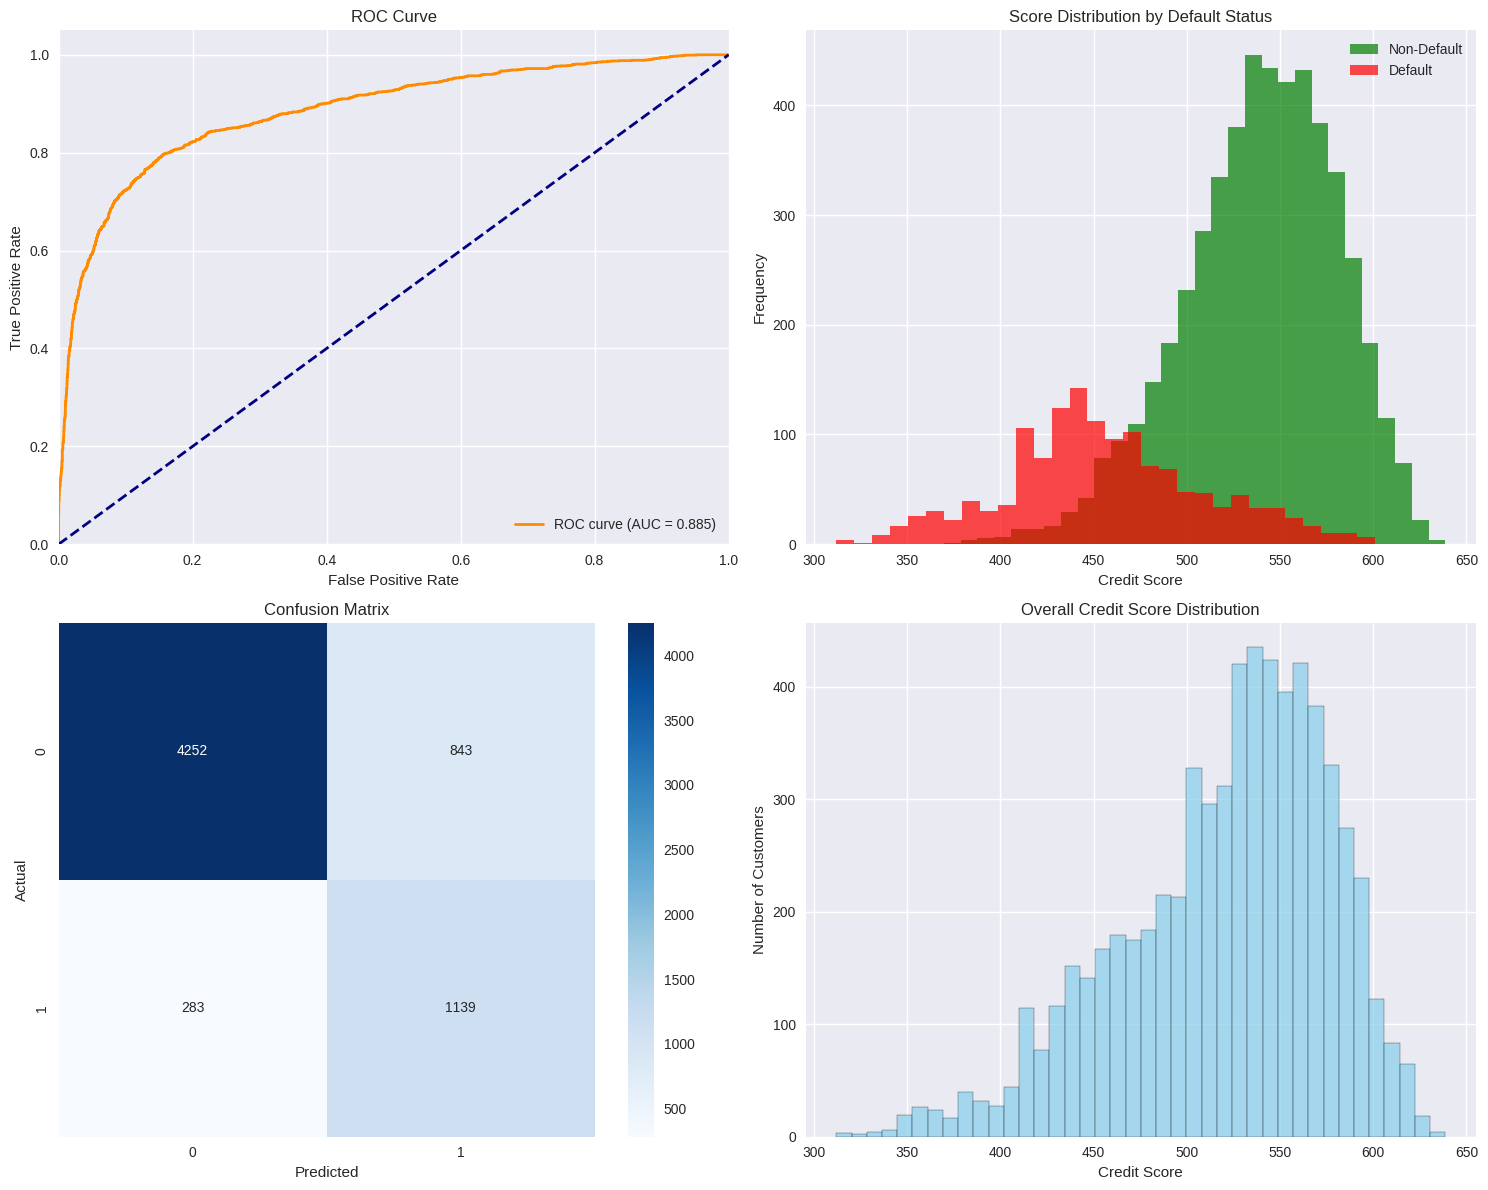


ROC AUC Score: 0.8845


In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

def evaluate_model_performance(scorecard, X_test, y_test, bin_processor):
    """
    Comprehensive model performance evaluation
    """
    # Transform test data for probability prediction
    X_test_binned = bin_processor.transform(X_test)

    # Get probability predictions
    y_pred_proba = scorecard.estimator_.predict_proba(X_test_binned)[:, 1]
    y_pred_class = (y_pred_proba > 0.5).astype(int)

    print("=== Model Performance Metrics ===")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_class))

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc_score = auc(fpr, tpr)

    # Plotting
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)

    # Score Distribution by Default Status
    scores_test = scorecard.score(X_test)
    ax2.hist(scores_test[y_test == 0], bins=30, alpha=0.7, label='Non-Default', color='green')
    ax2.hist(scores_test[y_test == 1], bins=30, alpha=0.7, label='Default', color='red')
    ax2.set_xlabel('Credit Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Score Distribution by Default Status')
    ax2.legend()
    ax2.grid(True)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
    ax3.set_title('Confusion Matrix')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')

    # Score Distribution Overall
    ax4.hist(scores_test, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
    ax4.set_xlabel('Credit Score')
    ax4.set_ylabel('Number of Customers')
    ax4.set_title('Overall Credit Score Distribution')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\nROC AUC Score: {roc_auc_score:.4f}")

    return y_pred_proba, roc_auc_score

# Evaluate model performance
predictions, auc_score = evaluate_model_performance(scorecard, X_test, y_test, bin_processor)


In [ ]:
def display_scorecard_details(scorecard):
    """
    Display detailed scorecard breakdown for business interpretation
    """
    # Get scorecard table
    scorecard_table = scorecard.table()

    print("=== Credit Scorecard Points Table ===")
    display(scorecard_table)

    # Group by variable for summary
    variable_summary = scorecard_table.groupby('Variable').agg({
        'Points': ['min', 'max', 'mean'],
        'Bin': 'count'
    }).round(2)

    variable_summary.columns = ['Min_Points', 'Max_Points', 'Avg_Points', 'Num_Bins']
    variable_summary = variable_summary.sort_values('Max_Points', ascending=False)

    print("\n=== Variable Points Summary ===")
    display(variable_summary)

    return scorecard_table

# Display scorecard details
scorecard_details = display_scorecard_details(scorecard)


=== Credit Scorecard Points Table ===


,Variable,Bin,Points
0,person_income,"(-inf, 22840.00)",0.000000
1,person_income,"[22840.00, 34990.00)",27.470883
2,person_income,"[34990.00, 39930.00)",42.159124
3,person_income,"[39930.00, 49996.50)",49.978457
4,person_income,"[49996.50, 59982.00)",50.591343
...,...,...,...
11,loan_percent_income,Missing,57.995262
0,cb_person_default_on_file,[N],0.477776
1,cb_person_default_on_file,[Y],0.000000
2,cb_person_default_on_file,Special,0.374716



=== Variable Points Summary ===


,Min_Points,Max_Points,Avg_Points,Num_Bins
Variable,,,,
loan_grade,0.0,84.62,53.29,6
loan_percent_income,0.0,81.18,55.99,12
person_income,0.0,78.43,48.09,10
person_home_ownership,0.0,36.25,16.27,5
loan_intent,0.0,32.40,13.30,8
loan_amnt,0.0,18.90,11.34,12
loan_int_rate,0.0,14.45,8.31,12
person_emp_length,0.0,1.02,0.53,10
cb_person_default_on_file,0.0,0.48,0.31,4


=== Risk Portfolio Analysis ===


,Customer_Count,Avg_Score,Default_Count,Default_Rate,Customer_Percentage
risk_bucket,,,,,
High Risk,639,429.7593,49.0,0.2988,9.81
Low Risk,257,610.8569,0.0,0.0000,3.94
Medium Risk,2272,526.9357,138.0,0.2527,34.86
Medium-High Risk,1149,476.5036,46.0,0.1783,17.63
Medium-Low Risk,2006,571.7423,47.0,0.1911,30.78
Very High Risk,194,371.2781,17.0,0.3148,2.98


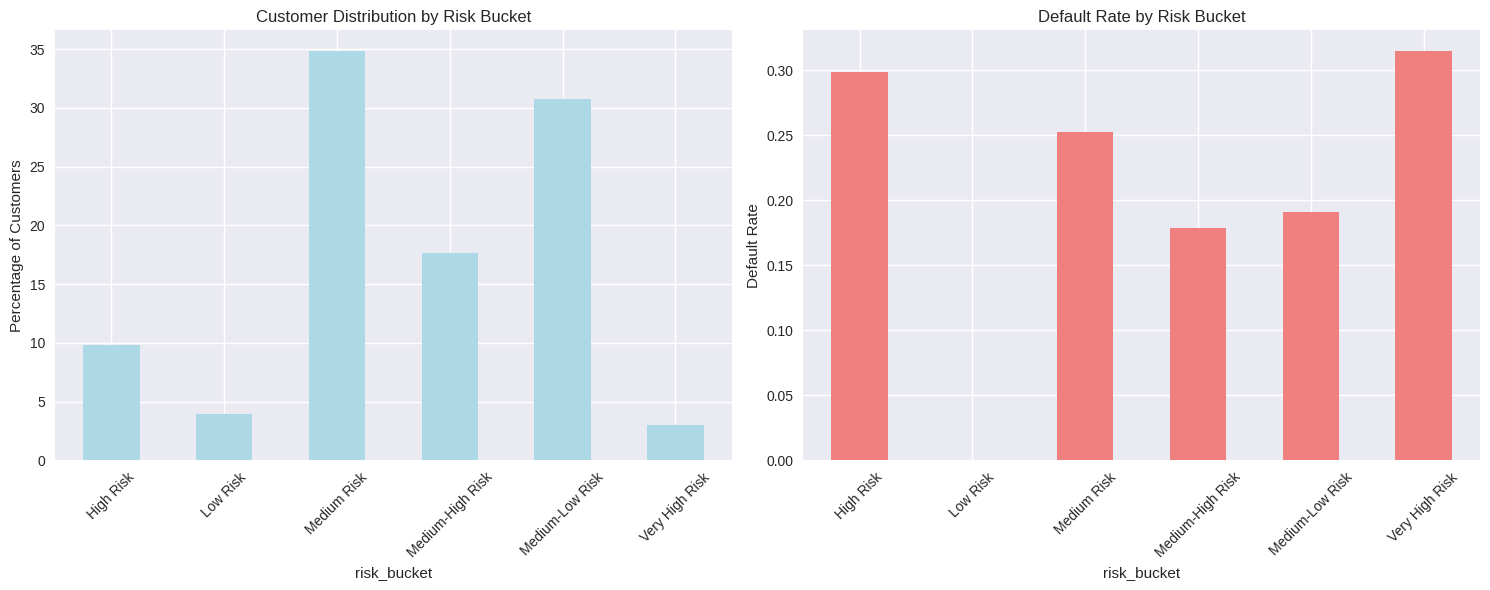

In [ ]:
def create_risk_portfolio_analysis(score_results):
    """
    Create comprehensive risk portfolio analysis
    """
    # Create risk buckets
    def create_risk_bucket(score):
        if score >= 650:
            return "Very Low Risk"
        elif score >= 600:
            return "Low Risk"
        elif score >= 550:
            return "Medium-Low Risk"
        elif score >= 500:
            return "Medium Risk"
        elif score >= 450:
            return "Medium-High Risk"
        elif score >= 400:
            return "High Risk"
        else:
            return "Very High Risk"

    score_results['risk_bucket'] = score_results['credit_score'].apply(create_risk_bucket)

    # Portfolio analysis
    portfolio_analysis = score_results.groupby('risk_bucket').agg({
        'credit_score': ['count', 'mean'],
        'actual_default': ['sum', 'mean']
    }).round(4)

    portfolio_analysis.columns = ['Customer_Count', 'Avg_Score', 'Default_Count', 'Default_Rate']
    portfolio_analysis['Customer_Percentage'] = (portfolio_analysis['Customer_Count'] /
                                                 portfolio_analysis['Customer_Count'].sum() * 100).round(2)

    print("=== Risk Portfolio Analysis ===")
    display(portfolio_analysis)

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Customer distribution by risk bucket
    portfolio_analysis['Customer_Percentage'].plot(kind='bar', ax=ax1, color='lightblue')
    ax1.set_title('Customer Distribution by Risk Bucket')
    ax1.set_ylabel('Percentage of Customers')
    ax1.tick_params(axis='x', rotation=45)

    # Default rate by risk bucket
    portfolio_analysis['Default_Rate'].plot(kind='bar', ax=ax2, color='lightcoral')
    ax2.set_title('Default Rate by Risk Bucket')
    ax2.set_ylabel('Default Rate')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return portfolio_analysis

# Create portfolio analysis
portfolio_stats = create_risk_portfolio_analysis(score_results)


In [ ]:
def save_model_artifacts(scorecard, bin_processor, file_prefix="credit_model"):
    """
    Save model artifacts for deployment
    """
    import pickle

    # Save scorecard
    with open(f'{file_prefix}_scorecard.pkl', 'wb') as f:
        pickle.dump(scorecard, f)

    # Save binning processor
    with open(f'{file_prefix}_binning.pkl', 'wb') as f:
        pickle.dump(bin_processor, f)

    print("Model artifacts saved successfully!")
    print(f"Files saved: {file_prefix}_scorecard.pkl, {file_prefix}_binning.pkl")

def score_new_customer(customer_data, scorecard_path, binning_path):
    """
    Score a new customer using saved model artifacts
    """
    import pickle

    # Load model artifacts
    with open(scorecard_path, 'rb') as f:
        scorecard = pickle.load(f)

    with open(binning_path, 'rb') as f:
        bin_processor = pickle.load(f)

    # Calculate score
    score = scorecard.score(customer_data)

    return score

# Save model for deployment
save_model_artifacts(scorecard, bin_processor)

print("=== Credit Scoring Model Development Complete ===")
print("Your credit scorecard is ready for production use!")


Model artifacts saved successfully!
Files saved: credit_model_scorecard.pkl, credit_model_binning.pkl
=== Credit Scoring Model Development Complete ===
Your credit scorecard is ready for production use!


In [ ]:
# Create a function to save all results to CSV files
def export_results_to_csv():
    """
    Export all credit scoring results to CSV files for download
    """
    print("=== Exporting Results to CSV Files ===")

    try:
        # 1. Export Variable Importance Analysis
        if 'importance_analysis' in globals():
            importance_analysis.to_csv('variable_importance_analysis.csv', index=False)
            print("✓ Variable importance analysis saved to: variable_importance_analysis.csv")

        # 2. Export Scorecard Points Table
        if 'scorecard' in globals():
            scorecard_table = scorecard.table()
            scorecard_table.to_csv('scorecard_points_table.csv', index=False)
            print("✓ Scorecard points table saved to: scorecard_points_table.csv")

        # 3. Export Credit Scores and Ratings
        if 'score_results' in globals():
            score_results.to_csv('credit_scores_and_ratings.csv', index=False)
            print("✓ Credit scores and ratings saved to: credit_scores_and_ratings.csv")

        # 4. Export Portfolio Analysis
        if 'portfolio_stats' in globals():
            portfolio_stats.to_csv('portfolio_risk_analysis.csv', index=True)
            print("✓ Portfolio risk analysis saved to: portfolio_risk_analysis.csv")

        # 5. Export Model Performance Metrics
        if 'X_test' in globals() and 'y_test' in globals():
            # Create performance summary
            performance_data = {
                'Metric': ['ROC AUC Score', 'Test Set Size', 'Default Rate'],
                'Value': [auc_score if 'auc_score' in globals() else 'N/A',
                         len(y_test),
                         y_test.mean()]
            }
            performance_df = pd.DataFrame(performance_data)
            performance_df.to_csv('model_performance_metrics.csv', index=False)
            print("✓ Model performance metrics saved to: model_performance_metrics.csv")

        # 6. Export Credit Rating Distribution
        if 'score_results' in globals():
            rating_distribution = score_results['credit_rating'].value_counts().reset_index()
            rating_distribution.columns = ['Credit_Rating', 'Customer_Count']
            rating_distribution['Percentage'] = (rating_distribution['Customer_Count'] /
                                               rating_distribution['Customer_Count'].sum() * 100).round(2)
            rating_distribution.to_csv('credit_rating_distribution.csv', index=False)
            print("✓ Credit rating distribution saved to: credit_rating_distribution.csv")

        # 7. Export Score Statistics by Rating
        if 'score_results' in globals():
            score_stats = score_results.groupby('credit_rating')['credit_score'].agg([
                'count', 'mean', 'min', 'max', 'std'
            ]).round(2).reset_index()
            score_stats.columns = ['Credit_Rating', 'Count', 'Mean_Score', 'Min_Score', 'Max_Score', 'Std_Score']
            score_stats.to_csv('score_statistics_by_rating.csv', index=False)
            print("✓ Score statistics by rating saved to: score_statistics_by_rating.csv")

        print("\n=== All CSV files have been created successfully! ===")

    except Exception as e:
        print(f"Error during export: {e}")

# Call the export function
export_results_to_csv()


=== Exporting Results to CSV Files ===
✓ Variable importance analysis saved to: variable_importance_analysis.csv
✓ Scorecard points table saved to: scorecard_points_table.csv
✓ Credit scores and ratings saved to: credit_scores_and_ratings.csv
✓ Portfolio risk analysis saved to: portfolio_risk_analysis.csv
✓ Model performance metrics saved to: model_performance_metrics.csv
✓ Credit rating distribution saved to: credit_rating_distribution.csv
✓ Score statistics by rating saved to: score_statistics_by_rating.csv

=== All CSV files have been created successfully! ===
